In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Dataset Loading

In [3]:
# Load ratings dataset
df = pd.read_csv("/kaggle/input/ml-latest-smol/ml-latest-small/ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Preparing the dataset for training

In [4]:
# Re-index users and movies to start from 0
user_ids = df["userId"].unique()
movie_ids = df["movieId"].unique()

user2idx = {u: i for i, u in enumerate(user_ids)}
movie2idx = {m: i for i, m in enumerate(movie_ids)}

df["userId"] = df["userId"].map(user2idx)
df["movieId"] = df["movieId"].map(movie2idx)

n_users = df["userId"].nunique()
n_movies = df["movieId"].nunique()

## updating movie profile and user profile Matrix (X & W)

In [5]:
def matrix_factorization(df, n_users, n_movies,
                               n=20, lr=0.005, reg=0.02, n_iters=100,
                               print_every=30, init_scale=0.01, seed=42):
    np.random.seed(seed)
    X = init_scale * np.random.randn(n_users, n)   # user factors
    W = init_scale * np.random.randn(n_movies, n)  # movie factors

    losses_mse = []
    n_ratings = len(df)

    for it in tqdm(range(1, n_iters+1), desc="Training Progress"):
        total_sq = 0.0

        # --- training updates (stochastic updates over observed ratings) ---
        for row in df.itertuples():
            u = int(row.userId)
            m = int(row.movieId)
            r = row.rating

            pred = X[u].dot(W[m])
            err = r - pred

            
            # gradient updates (SGD)
            X[u] += lr * (err * W[m] - reg * X[u])
            W[m] += lr * (err * X[u] - reg * W[m])

            total_sq += err**2

        # add regularization ONCE (not per rating)
        reg_term = reg * (np.sum(X * X) + np.sum(W * W))

        # average MSE over all ratings (include reg term averaged so scale matches)
        mse = (total_sq + reg_term) / n_ratings
        rmse = np.sqrt(mse)

        losses_mse.append(mse)

        # print at requested checkpoints (every print_every iterations)
        if it % print_every == 0 or it == 1 or it == n_iters:
            print(f"Iteration {it}/{n_iters} | MSE = {mse:.6f} | RMSE = {rmse:.4f}")

    return X, W, losses_mse


Training Progress:   0%|          | 1/200 [00:01<04:16,  1.29s/it]

Iteration 1/200 | MSE = 13.342636 | RMSE = 3.6528


Training Progress:  20%|██        | 40/200 [00:52<03:32,  1.33s/it]

Iteration 40/200 | MSE = 0.406386 | RMSE = 0.6375


Training Progress:  40%|████      | 80/200 [01:46<02:40,  1.34s/it]

Iteration 80/200 | MSE = 0.167085 | RMSE = 0.4088


Training Progress:  60%|██████    | 120/200 [02:39<01:46,  1.33s/it]

Iteration 120/200 | MSE = 0.109519 | RMSE = 0.3309


Training Progress:  80%|████████  | 160/200 [03:32<00:53,  1.33s/it]

Iteration 160/200 | MSE = 0.089213 | RMSE = 0.2987


Training Progress: 100%|██████████| 200/200 [04:25<00:00,  1.33s/it]

Iteration 200/200 | MSE = 0.079324 | RMSE = 0.2816


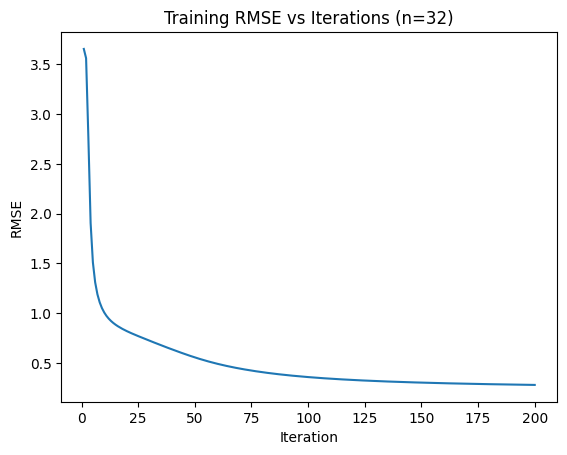

In [6]:
# assume df, n_users, n_movies already prepared (user/movie ids are 0..N-1)
n = 32
X, W, losses_mse = matrix_factorization(df, n_users, n_movies,
                                              n=n, lr=0.005, reg=0.01,
                                              n_iters=200, print_every=40,
                                              init_scale=0.01)

# plot MSE (or convert to RMSE for readability)
rmse_curve = np.sqrt(losses_mse)
plt.plot(range(1, len(rmse_curve)+1), rmse_curve)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title(f"Training RMSE vs Iterations (n={n})")
plt.show()

Training Progress:   2%|▏         | 1/50 [00:01<01:02,  1.28s/it]

Iteration 1/50 | MSE = 13.347736 | RMSE = 3.6535


Training Progress: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


Iteration 50/50 | MSE = 0.593279 | RMSE = 0.7702


Training Progress:   2%|▏         | 1/50 [00:01<01:02,  1.28s/it]

Iteration 1/50 | MSE = 13.347536 | RMSE = 3.6534


Training Progress: 100%|██████████| 50/50 [01:04<00:00,  1.30s/it]


Iteration 50/50 | MSE = 0.508405 | RMSE = 0.7130


Training Progress:   2%|▏         | 1/50 [00:01<01:02,  1.27s/it]

Iteration 1/50 | MSE = 13.346334 | RMSE = 3.6533


Training Progress: 100%|██████████| 50/50 [01:05<00:00,  1.30s/it]


Iteration 50/50 | MSE = 0.440974 | RMSE = 0.6641


Training Progress:   2%|▏         | 1/50 [00:01<01:03,  1.30s/it]

Iteration 1/50 | MSE = 13.345458 | RMSE = 3.6531


Training Progress: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


Iteration 50/50 | MSE = 0.359467 | RMSE = 0.5996


Training Progress:   2%|▏         | 1/50 [00:01<01:04,  1.31s/it]

Iteration 1/50 | MSE = 13.339891 | RMSE = 3.6524


Training Progress: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Iteration 50/50 | MSE = 0.266529 | RMSE = 0.5163


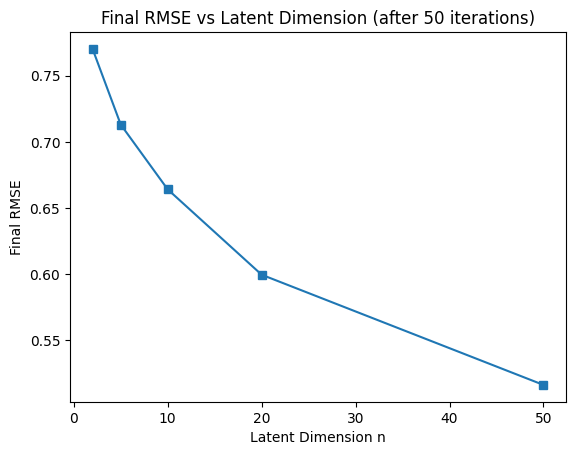

In [7]:
# Different latent dimensions to test
ns = [2, 5, 10, 20, 50]
final_rmse = []

for n in ns:
    X, W, losses_mse = matrix_factorization(
        df, n_users, n_movies,
        n=n, lr=0.005, reg=0.01,
        n_iters=50, print_every=100 # only show final
    )
    final_rmse.append(np.sqrt(losses_mse[-1]))

# Plot RMSE vs feature dimension
plt.plot(ns, final_rmse, marker='s')
plt.xlabel("Latent Dimension n")
plt.ylabel("Final RMSE")
plt.title("Final RMSE vs Latent Dimension (after 50 iterations)")
plt.show()


In [8]:
c

NameError: name 'c' is not defined